In [1]:
# if you do not like to install it
# import sys
# sys.path.insert(0,'../')

# DATA

In [2]:
import numpy as np
import pylab as plt
from os import path
from glob import glob
from tqdm import tqdm
# from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split

# import tfcook as tfc
import ktrans as ktr

In [3]:
image_size = 64

if path.exists("data.npz"):
    data = np.load('data.npz')
    x = data['x']
    y = data['y']
    n_class = len(np.unique(y))
else:
    import tensorflow_datasets as tfds
    ds = tfds.load('RockPaperScissors', split='train', shuffle_files=True)
    elms = []
    ii = 0
    for element in ds.as_numpy_iterator(): 
        elms.append(element) 
    #     if ii>10: break
    x = []
    y = []
    for i in range(len(elms)):
        x.append(elms[i]['image'])
        y.append(elms[i]['label'])
    x = np.array(x)
    y = np.array(y)
    xp = []
    for xi in x:
        xp.append(resize(xi,(image_size,image_size),preserve_range=1))
    x = np.array(xp)

    x = x.astype(np.float32)/255
    y = y.astype(int)

    labels = np.unique(y)
    n_class = len(labels)
    labelmap = {j:i for i,j in enumerate(labels)}
    y = [labelmap[i] for i in y]
    y = np.array(y)
    np.savez('data',x=x,y=y)


(2520, 64, 64, 3) (2520,) (756, 64, 64, 3) (756,) (1764, 64, 64, 3) (1764,)


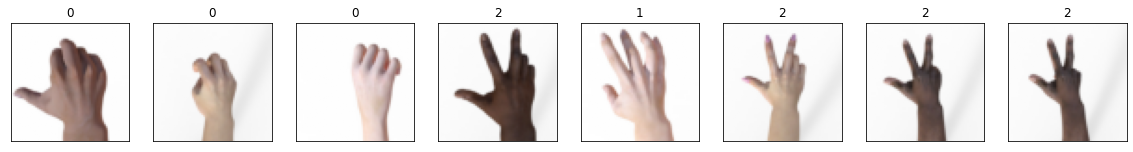

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

print(x.shape,y.shape,x_test.shape,y_test.shape,x_train.shape,y_train.shape)

image_size = x.shape[1]

fig,axs = plt.subplots(1,8,figsize=(20,6))
for i in range(8):
    ii = np.random.randint(x.shape[0])
    ax = axs[i]
    ax.imshow(x[ii])
    ax.set_title(y[ii])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [5]:
image_channels = x.shape[3]

n_latent = image_size
num_epochs = 20

In [6]:
batch_size = 128
classification_augmentation = {'input_shape':(image_size, image_size, image_channels),"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

labeled_train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                            .shuffle(buffer_size=10 * batch_size)
                            .batch(batch_size)
                        )

test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                  .shuffle(buffer_size=10 * batch_size)
                  .batch(batch_size)
                )

labeled_dataset_size = y_train.shape[0]

In [7]:
encoder1 = ktr.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

inp = keras.layers.Input(shape=(image_size, image_size, image_channels))
# xl = ktr.get_augmenter(**classification_augmentation)(inp)
xl = inp
for layer in encoder1.layers:
    xl = layer(xl)
out = layers.Dense(n_class)(xl)
model1 = keras.models.Model(inp,out,name='model1')
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                36928

In [8]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=50,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(
    optimizer=opt,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

0epoch [00:00, ?epoch/s]

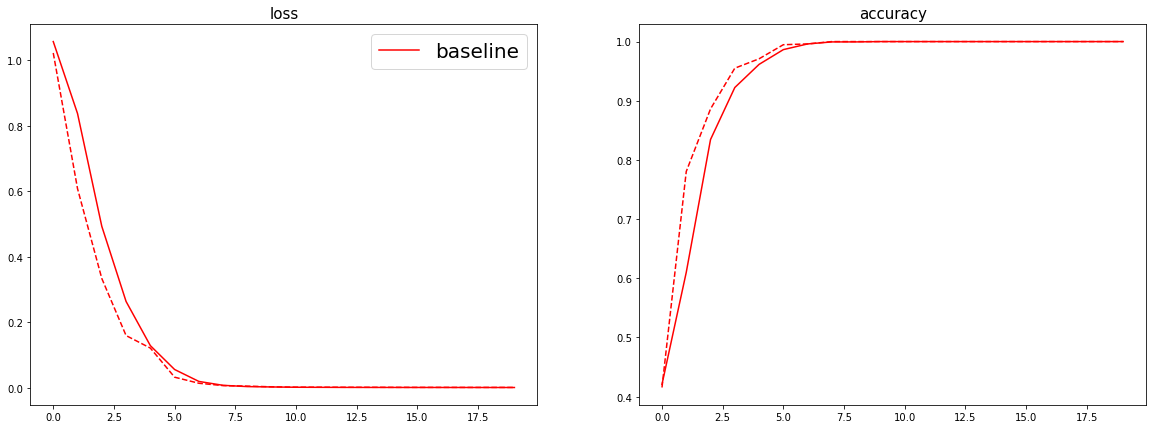

In [9]:
history1 = model1.fit(labeled_train_dataset,
                      epochs=num_epochs,
                      validation_data=test_dataset,
                      verbose=0,
                      callbacks=[TqdmCallback(verbose=0)]
                      )

hist = history1.history

label = 'baseline'
color = 'r'

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,7))

ax1.plot(hist['loss'],color=color,label=label)
ax1.plot(hist['val_loss'],color=color,ls='--')
ax1.set_title('loss',fontsize=15)

ax2.plot(hist['acc'],color=color)
ax2.plot(hist['val_acc'],color=color,ls='--')
ax2.set_title('accuracy',fontsize=15)

ax1.legend(fontsize=20)

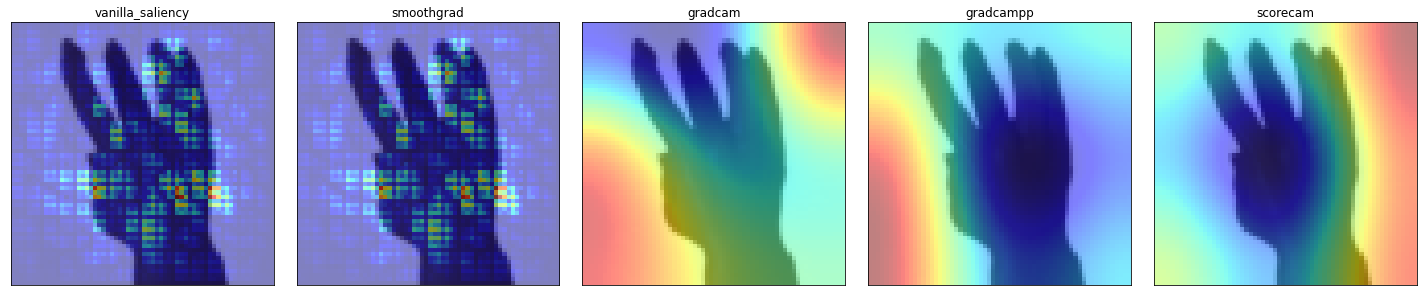

In [16]:
ii = np.random.randint(x.shape[0])

img = x[ii]
lbl = y[ii]
methods = [ktr.vanilla_saliency,ktr.smoothgrad,ktr.gradcam,ktr.gradcampp,ktr.scorecam]
m_name = ['vanilla_saliency','smoothgrad','gradcam','gradcampp','scorecam']
nmethods = len(methods)

fig,axs = plt.subplots(1,nmethods,figsize=(5*4,4))

for i in range(nmethods):

    smap = methods[i](img,model1,class_id=lbl)

#     axs[0,i].imshow(img)
#     axs[0,i].get_xaxis().set_visible(False)
#     axs[0,i].get_yaxis().set_visible(False)
    
    axs[i].imshow(img)
    axs[i].imshow(smap,cmap='jet',alpha=0.5)
    axs[i].set_title(m_name[i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.tight_layout()

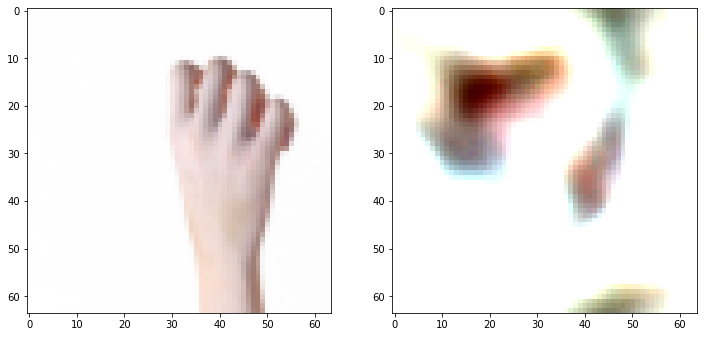

In [11]:
ii = np.random.randint(x.shape[0])

img = x[ii]
lbl = y[ii]
smap = ktr.activation_maximization(model=model1,class_id=lbl)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(img)
ax2.imshow(smap[0])

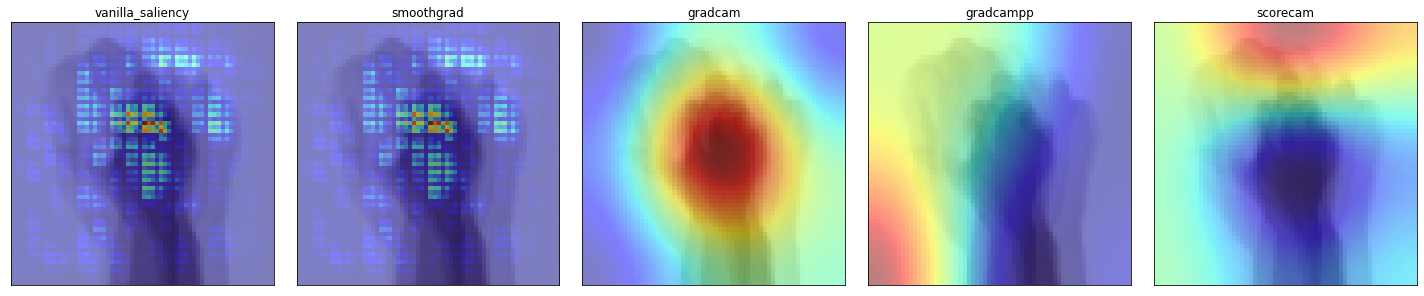

In [17]:
ii = np.random.randint(x.shape[0])

filt = y==0

img = x[filt][:10]
lbl = y[filt][:10]
methods = [ktr.vanilla_saliency,ktr.smoothgrad,ktr.gradcam,ktr.gradcampp,ktr.scorecam]
m_name = ['vanilla_saliency','smoothgrad','gradcam','gradcampp','scorecam']
nmethods = len(methods)

plt.close()
fig,axs = plt.subplots(1,nmethods,figsize=(5*4,4))

for i in range(nmethods):

    smap = methods[i](img,model1,class_id=lbl)

#     axs[0,i].imshow(np.mean(img,axis=0))
#     axs[0,i].get_xaxis().set_visible(False)
#     axs[0,i].get_yaxis().set_visible(False)
    
    axs[i].imshow(np.mean(img,axis=0))
    axs[i].imshow(np.mean(smap,axis=0),cmap='jet',alpha=0.5)
    axs[i].set_title(m_name[i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.tight_layout()